In [1]:
print("Hello C.R.A.P Mappers")

Hello C.R.A.P Mappers


## Working with SAR

We will use **Google Earth Engine**. If it doesn't give a good result, then boo! Meaning that we have to get the actual raw data and process it and everything. **Google Earth Engine** is written in Javascript complete with all the docs and it's **FREE!!**
<br>

#### We will be using **Sentinel 1** C-Band SAR data which on board on the ESA's Copernicus. The data has been preprocessed by [Google](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)
<br>

More on Sentinel 1 on [ESA](https://sentinel.esa.int/web/sentinel/missions/sentinel-1).

In [2]:
## check if EE is working
import ee
from IPython.display import Image
import pandas as pd
import time

# Initialize the Earth Engine module.
ee.Initialize()

# Display a thumbnail of a sample image asset.
Image(url=ee.Image('CGIAR/SRTM90_V4').getThumbUrl({'min': 0, 'max': 3000}))

## NYC Flood observation using SAR

The main idea here is that area with water will have clear **specular reflection** of the transmitted beam, which reflects little energy back to the sensor and therefore shown as a **low intensity value** in the image. 
<br>

In the case of urban flooding however, the main scattering mechanism is **double-bounce** due to the buildings due to **corner reflection**. In short, the beam would reflect on to the street and bounce back to the surrounding buildings before it gets back to the sensor. This means that if the street of an urban area is flooded, it would have **higher internsity value** instead of low due to the double-bounce mechanism. More on SAR image interpretation can be found [here](https://crisp.nus.edu.sg/~research/tutorial/sar_int.htm).

<br>

In our case, **NYC IS ESSENTIALLY A FOREST OF BUILDINGS**. Therefore, **double-bounce** is the dominant mechanism. There is also no apparent flood from the images and therefore we need to use **311 complaints** and **weather condition** as the proxy to a flooding event.



<br>

We can use these [CESBO Blog](http://www.cesbio.ups-tlse.fr/multitemp/?p=7717) and [this stack exchange example](https://gis.stackexchange.com/questions/306749/how-to-visualize-inundation-using-sentinel-1-sar-data) as reference on how to use GEE to analyze inundation. However, these code applies to SAR Images with obvious flooding and non-urban area. Thus, specular reflection is the main mechanism and low intensity area can be attributed to flooding.



In [3]:
## GET SENTINEL 1 within NYC FROM GEE 

# just a polygon of nyc based on Community District, this data is stored in my GEE
NYC = ee.FeatureCollection('users/vivaldirinaldi/nyc_communitydistrict') 
# use this to clip the image to nyc boundary


# Get the Sentinel 1 as an image collection
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                        .filterBounds(NYC) \
                        .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                        .filter(ee.Filter.eq('resolution_meters', 10)) \
                        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                        .sort('system:time_start')         



In [4]:
acquisition_times = ee.List(collection.aggregate_array('system:time_start')).getInfo() 
count = len(acquisition_times)


relativeorbit =  ee.List(collection.aggregate_array('relativeOrbitNumber_start')).getInfo()

imageID = ee.List(collection.aggregate_array('system:index')).getInfo() 

# see how many images
print(count)

178


In [6]:
imageID

['S1A_IW_GRDH_1SDV_20150312T225019_20150312T225048_005005_00645E_B3C6',
 'S1A_IW_GRDH_1SDV_20150317T225830_20150317T225855_005078_00661A_1F25',
 'S1A_IW_GRDH_1SDV_20150815T225027_20150815T225055_007280_009FA3_421A',
 'S1A_IW_GRDH_1SDV_20160330T225031_20160330T225100_010605_00FC80_CD02',
 'S1A_IW_GRDH_1SDV_20160416T225854_20160416T225919_010853_0103E5_F2DB',
 'S1A_IW_GRDH_1SDV_20160423T225038_20160423T225107_010955_01070D_7507',
 'S1A_IW_GRDH_1SDV_20160517T225042_20160517T225111_011305_011234_5FA6',
 'S1A_IW_GRDH_1SDV_20160610T225043_20160610T225112_011655_011D66_6541',
 'S1A_IW_GRDH_1SDV_20160704T225045_20160704T225114_012005_012882_E310',
 'S1A_IW_GRDH_1SDV_20160709T225858_20160709T225923_012078_012AF0_FEE9',
 'S1A_IW_GRDH_1SDV_20160716T225038_20160716T225106_012180_012E41_2308',
 'S1A_IW_GRDH_1SDV_20160728T225046_20160728T225115_012355_0133F4_9729',
 'S1A_IW_GRDH_1SDV_20160821T225047_20160821T225116_012705_013F9D_E630',
 'S1A_IW_GRDH_1SDV_20160914T225048_20160914T225112_013055_014B1D

Here we basically created an image collection of Sentinel 1 SAR images on NYC area. In this case, there are 2 different orbits with only one that has the most coverage of NYC. 

In [48]:
## get a list of available time
epoch = list(map(int, acquisition_times))

def epoch2human(epoch):
    return time.strftime('%Y-%m-%d', 
        time.localtime(int(epoch)/1000.0)) 
    
sensingDate = [epoch2human(t) for t in epoch]


SensingDate = pd.DataFrame({'ID':imageID, 'sensing_date':sensingDate, 'orbit':relativeorbit})

## orbit 33 has the most coverage of NYC so we use that

blob = SensingDate

SensingDate =  SensingDate.loc[SensingDate['orbit']==33.0].reset_index(drop=True)


SensingDate.head()

,ID,sensing_date,orbit
0,S1A_IW_GRDH_1SDV_20150312T225019_20150312T2250...,2015-03-12,33.0
1,S1A_IW_GRDH_1SDV_20150815T225027_20150815T2250...,2015-08-15,33.0
2,S1A_IW_GRDH_1SDV_20160330T225031_20160330T2251...,2016-03-30,33.0
3,S1A_IW_GRDH_1SDV_20160423T225038_20160423T2251...,2016-04-23,33.0
4,S1A_IW_GRDH_1SDV_20160517T225042_20160517T2251...,2016-05-17,33.0


In [49]:
blob

,ID,sensing_date,orbit
0,S1A_IW_GRDH_1SDV_20150312T225019_20150312T2250...,2015-03-12,33.0
1,S1A_IW_GRDH_1SDV_20150317T225830_20150317T2258...,2015-03-17,106.0
2,S1A_IW_GRDH_1SDV_20150815T225027_20150815T2250...,2015-08-15,33.0
3,S1A_IW_GRDH_1SDV_20160330T225031_20160330T2251...,2016-03-30,33.0
4,S1A_IW_GRDH_1SDV_20160416T225854_20160416T2259...,2016-04-16,106.0
5,S1A_IW_GRDH_1SDV_20160423T225038_20160423T2251...,2016-04-23,33.0
6,S1A_IW_GRDH_1SDV_20160517T225042_20160517T2251...,2016-05-17,33.0
7,S1A_IW_GRDH_1SDV_20160610T225043_20160610T2251...,2016-06-10,33.0
8,S1A_IW_GRDH_1SDV_20160704T225045_20160704T2251...,2016-07-04,33.0
9,S1A_IW_GRDH_1SDV_20160709T225858_20160709T2259...,2016-07-09,106.0


## 311 complainst as proxy to flood event
The data is retrieved from NYC Open Data and wrangled to only consist of those with Sewer Backup, Catch Basin Clogged/Flooding, Culvert Blocked/Needs Cleaning, and Street Flooding. The data is also filtered to have the same range as Sentinel 1 data.

In [8]:
# download 311 as csv if u want
#!wget https://nycopendata.socrata.com/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD 

In [9]:
# read all 311 data for DEP
calls = pd.read_csv('opendatacompiled.csv')
calls.columns
calls.shape

(70665, 6)

In [10]:
calls.descriptor.unique()

array(['Sewer Backup (Use Comments) (SA)',
       'Catch Basin Clogged/Flooding (Use Comments) (SC)',
       'Culvert Blocked/Needs Cleaning (SE)', 'Street Flooding (SJ)'],
      dtype=object)

In [11]:
# make a datetime to get date only
calls['created_date'] = pd.to_datetime(calls.created_date)
calls['call_date'] = calls['created_date'].dt.date

# get how many calls for all unique dates
bydate = pd.DataFrame(calls.groupby(['call_date']).count())
bydate['date'] = bydate.index
bydate = bydate[['date', 'created_date']].reset_index(drop=True)
bydate['join'] = bydate['date'].astype(str)
bydate.head()

,date,created_date,join
0,2016-05-02,74,2016-05-02
1,2016-05-03,123,2016-05-03
2,2016-05-04,63,2016-05-04
3,2016-05-05,60,2016-05-05
4,2016-05-06,175,2016-05-06


In [12]:
# join 311 with sensing date
Sensing311 = SensingDate.merge(bydate, left_on = 'sensing_date', right_on = 'join')
Sensing311 = Sensing311[['ID','sensing_date', 'created_date']].sort_values(by='created_date', ascending=False)
Sensing311.head(10)

,ID,sensing_date,created_date
22,S1A_IW_GRDH_1SDV_20170406T225050_20170406T2251...,2017-04-06,338
59,S1A_IW_GRDH_1SDV_20180811T225104_20180811T2251...,2018-08-11,314
69,S1A_IW_GRDH_1SDV_20181221T225104_20181221T2251...,2018-12-21,308
63,S1A_IW_GRDH_1SDV_20180928T225106_20180928T2251...,2018-09-28,255
17,S1A_IW_GRDH_1SDV_20170124T225037_20170124T2251...,2017-01-24,235
46,S1A_IW_GRDH_1SDV_20180308T225056_20180308T2251...,2018-03-08,180
68,S1A_IW_GRDH_1SDV_20181127T225105_20181127T2251...,2018-11-27,158
52,S1A_IW_GRDH_1SDV_20180519T225059_20180519T2251...,2018-05-19,123
57,S1A_IW_GRDH_1SDV_20180718T225102_20180718T2251...,2018-07-18,117
50,S1A_IW_GRDH_1SDV_20180425T225057_20180425T2251...,2018-04-25,115


## Precipitation during the sensing day
The data from 2015 to 8 June 2019 obtained from [NOAA Data Tools](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd) through online request made. 
<br>

We want to cross reference the 311 calls with the precipitation during and within the day of the sensing time. Therefore, we would need to get the **daily sum and average precipitation** as well as the **sum and average precipitaiton of during the sensing**.
<br>

Documentation on the data can be found [here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf).


In [13]:
# read in weather data 
weather = pd.read_csv("weather_2015_8June2019.csv")
weather.columns

C:\Users\Rinal\.conda\envs\geoEnv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3,5,7,8,11,14,30,31,32,33,34,41,42,43,44,48,49,51,52,53,54,56,58,59,69,72,73,75,76,88,89,95,96,97,98,99,100,101,102,103,104,105,106,107,117,119,123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['STATION', 'DATE', 'REPORT_TYPE', 'SOURCE', 'AWND', 'BackupDirection',
       'BackupDistance', 'BackupDistanceUnit', 'BackupElements',
       'BackupElevation',
       ...
       'ShortDurationPrecipitationValue060',
       'ShortDurationPrecipitationValue080',
       'ShortDurationPrecipitationValue100',
       'ShortDurationPrecipitationValue120',
       'ShortDurationPrecipitationValue150',
       'ShortDurationPrecipitationValue180', 'Sunrise', 'Sunset', 'TStorms',
       'WindEquipmentChangeDate'],
      dtype='object', length=124)

In [14]:
## wrangle date field
weather.DATE = pd.to_datetime(weather.DATE)
weather['recordDate'] = weather.DATE.dt.date
weather['recordHour'] = weather.DATE.dt.hour


In [15]:
# make a new df to work with 
wdf = weather[['recordDate', 'recordHour', 'DailyPrecipitation', 'HourlyPrecipitation']]


In [16]:
for i in ['DailyPrecipitation', 'HourlyPrecipitation']:
    print(i)

DailyPrecipitation
HourlyPrecipitation


In [17]:
# clean the data and stuff you know

for i in ['DailyPrecipitation', 'HourlyPrecipitation']:
    wdf[i] = wdf[i].str.replace('T', '0', regex=False)
    wdf[i] = wdf[i].str.replace('s', '', regex=False)
    wdf[i].fillna(0.00, inplace=True)
    wdf[i] = wdf[i].astype(float)



C:\Users\Rinal\.conda\envs\geoEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Rinal\.conda\envs\geoEnv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Rinal\.conda\envs\geoEnv\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [18]:
## get daily Sum of rain
dailySum = wdf[['recordDate','DailyPrecipitation']].groupby(['recordDate']).max().rename(index=str, columns={"DailyPrecipitation": "dailySum"})
dailySum.head()

,dailySum
recordDate,
2015-01-01,0.00
2015-01-02,0.00
2015-01-03,0.94
2015-01-04,0.47
2015-01-05,0.00


In [19]:
# get daily average or rain
dailyAvg = wdf[['recordDate','HourlyPrecipitation']].groupby(['recordDate']).max().rename(index=str, columns={"HourlyPrecipitation": "dailyMean"})
dailyAvg.head()

,dailyMean
recordDate,
2015-01-01,0.00
2015-01-02,0.00
2015-01-03,0.15
2015-01-04,0.18
2015-01-05,0.00


In [20]:
## so also want to get the precipitation condition during the sensing, which is about 10:55pm
## at the same time,we wanna know if it's raining since before or it's the begining
## so we should get 1 hr before and after

wdfHourly = wdf.loc[wdf['recordHour'] >= 22]
senseHourAvg = wdfHourly[['recordDate','HourlyPrecipitation']].groupby(['recordDate']).mean()

senseHourAvg = senseHourAvg.rename(index=str, columns={"HourlyPrecipitation": "senseMean"})
senseHourAvg.head()



,senseMean
recordDate,
2015-01-01,0.000000
2015-01-02,0.000000
2015-01-03,0.024118
2015-01-04,0.000000
2015-01-05,0.000000


In [21]:
wdfSumHourly = wdf.loc[wdf['recordHour'] >= 21]
senseHourSum = wdfSumHourly[['recordDate','HourlyPrecipitation']].groupby(['recordDate']).sum().rename(index=str, columns={"HourlyPrecipitation": "senseSum"})
senseHourSum.head()

,senseSum
recordDate,
2015-01-01,0.00
2015-01-02,0.00
2015-01-03,0.67
2015-01-04,0.04
2015-01-05,0.00


In [22]:
## join all of that as precipitation DF
precipitation = dailySum.join(dailyAvg).join(senseHourSum.join(senseHourAvg))
precipitation['Date'] = precipitation.index.astype(str)
precipitation = precipitation.reset_index(drop=True)
precipitation.head()

,dailySum,dailyMean,senseSum,senseMean,Date
0,0.00,0.00,0.00,0.000000,2015-01-01
1,0.00,0.00,0.00,0.000000,2015-01-02
2,0.94,0.15,0.67,0.024118,2015-01-03
3,0.47,0.18,0.04,0.000000,2015-01-04
4,0.00,0.00,0.00,0.000000,2015-01-05


Now that we have that, we have to merge it with the sensing date

## Merge 311 and precipitation based on sensing date

In [23]:
## FINAL DATA YO
Sensing311Precip = Sensing311.merge(precipitation, left_on = 'sensing_date', right_on = 'Date')
Sensing311Precip = Sensing311Precip.drop(['Date'], axis=1)

## rename them
Sensing311Precip = Sensing311Precip.rename(index=str, columns={'sensing_date':'sensingDate','created_date':'total311'})

Sensing311Precip.head()

,ID,sensingDate,total311,dailySum,dailyMean,senseSum,senseMean
0,S1A_IW_GRDH_1SDV_20170406T225050_20170406T2251...,2017-04-06,338,0.96,0.58,0.00,0.000000
1,S1A_IW_GRDH_1SDV_20180811T225104_20180811T2251...,2018-08-11,314,2.90,1.69,0.00,0.000000
2,S1A_IW_GRDH_1SDV_20181221T225104_20181221T2251...,2018-12-21,308,1.73,0.37,0.00,0.000000
3,S1A_IW_GRDH_1SDV_20180928T225106_20180928T2251...,2018-09-28,255,1.26,0.73,0.00,0.000000
4,S1A_IW_GRDH_1SDV_20170124T225037_20170124T2251...,2017-01-24,235,1.22,0.33,0.14,0.002857


In [24]:
## sort em sort sort.. sort em
SortedSensing = Sensing311Precip.sort_values(by=['total311', 'dailySum', 'senseSum', 'senseMean'], ascending=False)

## 311 complaints and precipitation
To be more sure on the relationship between 311 and precipitation, we should see the correlation between them.

In [25]:
# Scalled the values to make a comparible 
from sklearn.preprocessing import MinMaxScaler

SensingScaled = Sensing311Precip

scaler = MinMaxScaler()

SensingScaled[['total311', 'dailySum', 'senseSum', 'senseMean']] = scaler.fit_transform(SensingScaled[['total311', 'dailySum', 'senseSum', 'senseMean']])

SensingScaled['sensingDate'] = pd.to_datetime(SensingScaled['sensingDate'])
SensingScaled.head()

,ID,sensingDate,total311,dailySum,dailyMean,senseSum,senseMean
0,S1A_IW_GRDH_1SDV_20170406T225050_20170406T2251...,2017-04-06,1.000000,0.331034,0.58,0.000000,0.000000
1,S1A_IW_GRDH_1SDV_20180811T225104_20180811T2251...,2018-08-11,0.925234,1.000000,1.69,0.000000,0.000000
2,S1A_IW_GRDH_1SDV_20181221T225104_20181221T2251...,2018-12-21,0.906542,0.596552,0.37,0.000000,0.000000
3,S1A_IW_GRDH_1SDV_20180928T225106_20180928T2251...,2018-09-28,0.741433,0.434483,0.73,0.000000,0.000000
4,S1A_IW_GRDH_1SDV_20170124T225037_20170124T2251...,2017-01-24,0.679128,0.420690,0.33,0.061404,0.026667


Populating the interactive namespace from numpy and matplotlib


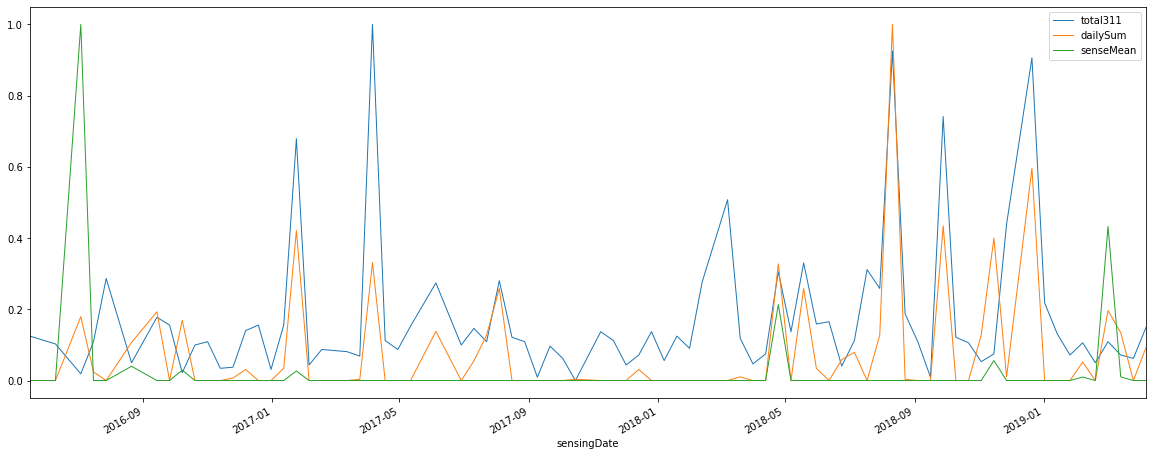

In [26]:
import pylab as pl

%pylab inline

f, ax = pl.subplots(figsize=(20, 8))
SensingScaled.plot(x='sensingDate', y='total311', linewidth=1, fontsize= 10,
                     ax = ax, grid=False, x_compat=True, label = 'total311')
SensingScaled.plot(x='sensingDate', y='dailySum', linewidth=1, fontsize= 10,
                     ax = ax, grid=False, x_compat=True, label = 'dailySum')
SensingScaled.plot(x='sensingDate', y='senseMean', linewidth=1, fontsize= 10,
                     ax = ax, grid=False, x_compat=True, label = 'senseMean')

In [27]:
## See correlation
SensingScaled[['total311', 'dailySum', 'senseSum', 'senseMean']].corr()

,total311,dailySum,senseSum,senseMean
total311,1.000000,0.738435,-0.082854,-0.080562
dailySum,0.738435,1.000000,0.205153,0.153606
senseSum,-0.082854,0.205153,1.000000,0.976251
senseMean,-0.080562,0.153606,0.976251,1.000000


Hmm... It's interesting to see the correlation. Meaning that if there is rain or more inches of precipitation, it is more likely that people complain on 311. I mean obviously duh...

In [28]:
## can we confirm that?

# join precip and 311 count 
precip311 = bydate.merge(precipitation, left_on= 'join', right_on = 'Date')
precip311 = precip311[['date', 'created_date', 'dailySum']]

precip311Scaled = precip311
## scale em
precip311Scaled[['created_date', 'dailySum']] = scaler.fit_transform(precip311Scaled[['created_date', 'dailySum']])
precip311Scaled['date'] = pd.to_datetime(precip311Scaled['date'])

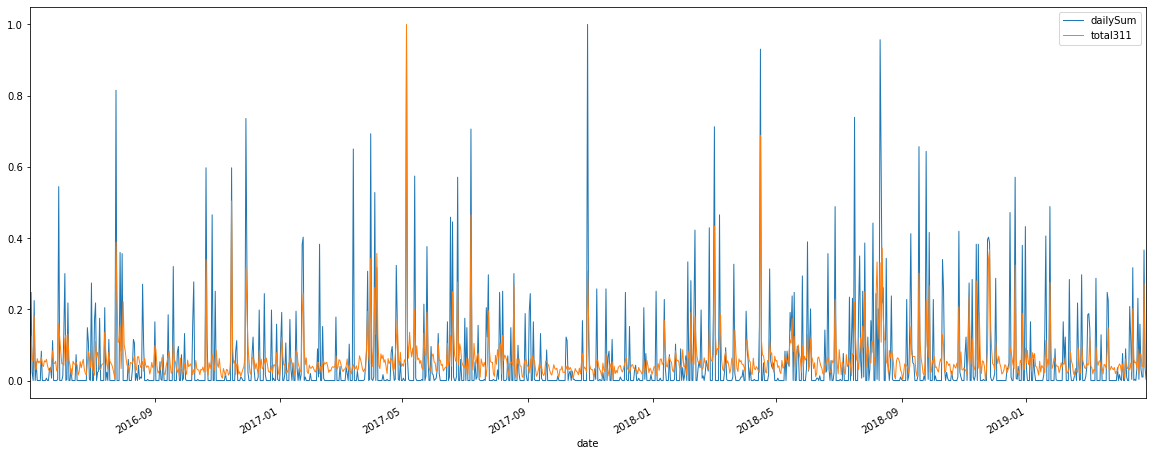

In [29]:
f, ax = pl.subplots(figsize=(20, 8))

precip311.plot(x='date', y='dailySum', linewidth=1, fontsize= 10,
                ax = ax, grid=False, x_compat=True, label = 'dailySum')
precip311.plot(x='date', y='created_date', linewidth=1, fontsize= 10,
                     ax = ax, grid=False, x_compat=True, label = 'total311')


In [30]:
precip311Scaled[['date', 'created_date', 'dailySum']].corr()

,created_date,dailySum
created_date,1.000000,0.735201
dailySum,0.735201,1.000000


About the same...

In this case then, we can say that totall 311 and total precipitation are inidicative of flooding event in New York City. Therfore we can select the right images based on these two attributes.

## Getting the candidate images
Let's see which dates has the most and the least 311 calls and precipitation 

In [31]:
## see which date has the most rain and flood
SortedSensing.sort_values(by= ['dailySum'], ascending= False).head(10)

,ID,sensingDate,total311,dailySum,dailyMean,senseSum,senseMean
1,S1A_IW_GRDH_1SDV_20180811T225104_20180811T2251...,2018-08-11,314,2.90,1.69,0.00,0.000000
2,S1A_IW_GRDH_1SDV_20181221T225104_20181221T2251...,2018-12-21,308,1.73,0.37,0.00,0.000000
3,S1A_IW_GRDH_1SDV_20180928T225106_20180928T2251...,2018-09-28,255,1.26,0.73,0.00,0.000000
4,S1A_IW_GRDH_1SDV_20170124T225037_20170124T2251...,2017-01-24,235,1.22,0.33,0.14,0.002857
56,S1A_IW_GRDH_1SDV_20181115T225106_20181115T2251...,2018-11-15,41,1.16,0.24,0.64,0.006000
0,S1A_IW_GRDH_1SDV_20170406T225050_20170406T2251...,2017-04-06,338,0.96,0.58,0.00,0.000000
9,S1A_IW_GRDH_1SDV_20180425T225057_20180425T2251...,2018-04-25,115,0.95,0.28,0.48,0.022857
7,S1A_IW_GRDH_1SDV_20180519T225059_20180519T2251...,2018-05-19,123,0.75,0.25,0.04,0.000000
11,S1A_IW_GRDH_1SDV_20170804T225057_20170804T2251...,2017-08-04,107,0.75,0.64,0.00,0.000000
39,S1A_IW_GRDH_1SDV_20190303T225103_20190303T2251...,2019-03-03,52,0.57,0.14,1.26,0.046364


In [32]:
## see which date has the least
SortedSensing.tail(50)

,ID,sensingDate,total311,dailySum,dailyMean,senseSum,senseMean
29,S1A_IW_GRDH_1SDV_20171226T225057_20171226T2251...,2017-12-26,61,0.00,0.00,0.00,0.000000
30,S1A_IW_GRDH_1SDV_20190114T225104_20190114T2251...,2019-01-14,59,0.00,0.00,0.00,0.000000
31,S1A_IW_GRDH_1SDV_20180119T225057_20180119T2251...,2018-01-19,57,0.00,0.00,0.00,0.000000
32,S1A_IW_GRDH_1SDV_20160517T225042_20160517T2251...,2016-05-17,57,0.00,0.00,0.00,0.000000
33,S1A_IW_GRDH_1SDV_20181010T225106_20181010T2251...,2018-10-10,56,0.00,0.00,0.00,0.000000
34,S1A_IW_GRDH_1SDV_20170816T225057_20170816T2251...,2017-08-16,56,0.00,0.00,0.00,0.000000
35,S1A_IW_GRDH_1SDV_20180320T225056_20180320T2251...,2018-03-20,55,0.03,0.02,0.00,0.000000
36,S1A_IW_GRDH_1SDV_20180706T225101_20180706T2251...,2018-07-06,53,0.23,0.09,0.00,0.000000
37,S1A_IW_GRDH_1SDV_20171120T225059_20171120T2251...,2017-11-20,53,0.00,0.00,0.00,0.000000
38,S1A_IW_GRDH_1SDV_20170418T225051_20170418T2251...,2017-04-18,53,0.00,0.00,0.00,0.000000


So we can use either **2017-04-06** or **2018-08-11** or **2018-12-21** as the wet images and either **2017-10-15** or **2017-09-09** or **2018-09-16** as the dry images.

I am a little more confident on image from **2018-08-11** since it has the most total precipitation and only ~6% less call than on the day with the highest number of calls. In such case, we could use **2018-09-16** since it's only 3 sensing apart.

In [33]:
SortedSensing['sensingDate'] = pd.to_datetime(SortedSensing['sensingDate'])

In [45]:
SortedSensing.loc[SortedSensing['sensingDate'].dt.year == 2019].sort_values(by = ['sensingDate'])

,ID,sensingDate,total311,dailySum,dailyMean,senseSum,senseMean
15,S1A_IW_GRDH_1SDV_20190102T225104_20190102T2251...,2019-01-02,87,0.00,0.00,0.00,0.000000
30,S1A_IW_GRDH_1SDV_20190114T225104_20190114T2251...,2019-01-14,59,0.00,0.00,0.00,0.000000
59,S1A_IW_GRDH_1SDV_20190126T225103_20190126T2251...,2019-01-26,40,0.00,0.00,0.00,0.000000
46,S1A_IW_GRDH_1SDV_20190207T225103_20190207T2251...,2019-02-07,51,0.15,0.11,0.02,0.001053
65,S1A_IW_GRDH_1SDV_20190219T225102_20190219T2251...,2019-02-19,33,0.00,0.00,0.00,0.000000
39,S1A_IW_GRDH_1SDV_20190303T225103_20190303T2251...,2019-03-03,52,0.57,0.14,1.26,0.046364
58,S1A_IW_GRDH_1SDV_20190315T225103_20190315T2251...,2019-03-15,40,0.39,0.37,0.13,0.001111
61,S1A_IW_GRDH_1SDV_20190327T225103_20190327T2251...,2019-03-27,37,0.00,0.00,0.00,0.000000
24,S1A_IW_GRDH_1SDV_20190408T225103_20190408T2251...,2019-04-08,65,0.27,0.23,0.00,0.000000


In [35]:
## query ID for specific date
wow = SortedSensing.loc[SortedSensing['sensingDate']== '2018-07-18' ]
wow['ID'][0]

'S1A_IW_GRDH_1SDV_20180718T225102_20180718T225127_022855_027A73_4435'

## See the SAR images from these 2 dates using Earth Engine
Technically, we could get the image without filtering the dates if we have the image id, which we can get from ASF Vertex api but it'll require us to wrangle a little more. We can use the ID and call it as an image object.

In [36]:
# uncomment the line to retrieve a list of available images using ASF Vertex API

## API call
#!curl https://api.daac.asf.alaska.edu/services/search/param?platform=Sentinel-1\&frame=130\&relativeOrbit=30\&output=csv > S1_list.csv

## Read data
#S1= pd.read_csv("S1_list.csv")
#S1.head()

In [37]:
## need this bound to plot it here
bound = NYC.geometry().bounds().getInfo()['coordinates']
bound

[[[-74.25556465375254, 40.49611715451909],
  [-73.69999965139206, 40.49611715451909],
  [-73.69999965139206, 40.91554827023569],
  [-74.25556465375254, 40.91554827023569],
  [-74.25556465375254, 40.49611715451909]]]

In [38]:
# get id for day with max dailySum
wetID = SortedSensing.loc[SortedSensing['dailySum'].idxmax()].ID

# call an image
wet = ee.Image('COPERNICUS/S1_GRD/'+ wetID).clip(NYC)

print('COPERNICUS/S1_GRD/'+ wetID)

COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20180811T225104_20180811T225129_023205_028585_6C71


In [39]:
# image with the dryest condition
dryID = SortedSensing.loc[SortedSensing['sensingDate']== '2018-09-16' ]
dryID = dryID['ID'][0]

dry = ee.Image('COPERNICUS/S1_GRD/'+ str(dryID)).clip(NYC)

print('COPERNICUS/S1_GRD/'+ dryID)

COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20180916T225105_20180916T225130_023730_02965B_9B45


In [40]:
# Dry as reference
Image(url=dry.select(['VV']).getThumbUrl({'region':bound, 'min': -25, 'max': 0}))

In [41]:
## show VV polarization
Image(url=wet.select(['VV']).getThumbUrl({'region':bound, 'min': -25, 'max': 0}))

Really hard to tell if it changes...
  

### Export the calls for the rainiest day

In [42]:
calls.head()

,created_date,address_type,descriptor,resolution_description,x_coordinate_state_plane,y_coordinate_state_plane,call_date
0,2019-03-29 08:15:00,ADDRESS,Sewer Backup (Use Comments) (SA),The Department of Environmental Protection inv...,955186.0,164345.0,2019-03-29
1,2019-03-29 21:03:00,ADDRESS,Sewer Backup (Use Comments) (SA),The Department of Environmental Protection inv...,1066818.0,212476.0,2019-03-29
2,2019-03-29 09:42:00,ADDRESS,Sewer Backup (Use Comments) (SA),The Department of Environmental Protection has...,932278.0,144366.0,2019-03-29
3,2019-03-29 09:16:00,ADDRESS,Sewer Backup (Use Comments) (SA),The Department of Environmental Protection inv...,1003610.0,161078.0,2019-03-29
4,2019-03-29 09:12:00,ADDRESS,Sewer Backup (Use Comments) (SA),The Department of Environmental Protection has...,1050113.0,203038.0,2019-03-29


In [43]:
calls.call_date.unique()

array([datetime.date(2019, 3, 29), datetime.date(2019, 2, 11),
       datetime.date(2019, 3, 30), ..., datetime.date(2019, 2, 26),
       datetime.date(2019, 2, 27), datetime.date(2019, 2, 28)],
      dtype=object)

In [44]:
calls.loc[calls['call_date'] == datetime.date(2018, 8, 11)].to_csv('calls081118.csv')